# 多路召回 

所谓的“多路召回”策略，就是指采用不同的策略、特征或简单模型，分别召回一部分候选集，然后把候选集混合在一起供后续排序模型使用，可以明显的看出，“多路召回策略”是在“计算速度”和“召回率”之间进行权衡的结果。其中，各种简单策略保证候选集的快速召回，从不同角度设计的策略保证召回率接近理想的状态，不至于损伤排序效果。如下图是多路召回的一个示意图，在多路召回中，每个策略之间毫不相关，所以一般可以写并发多线程同时进行，这样可以更加高效。

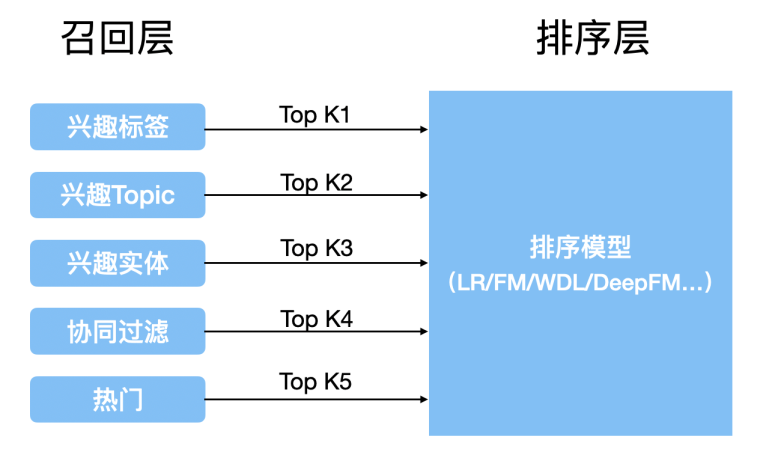

上图只是一个多路召回的例子，也就是说可以使用多种不同的策略来获取用户排序的候选商品集合，而具体使用哪些召回策略其实是与业务强相关的 ，针对不同的任务就会有对于该业务真实场景下需要考虑的召回规则。例如新闻推荐，召回规则可以是“热门新闻”、“作者召回”、“关键词召回”、“主题召回“、”协同过滤召回“等等。

### 导包

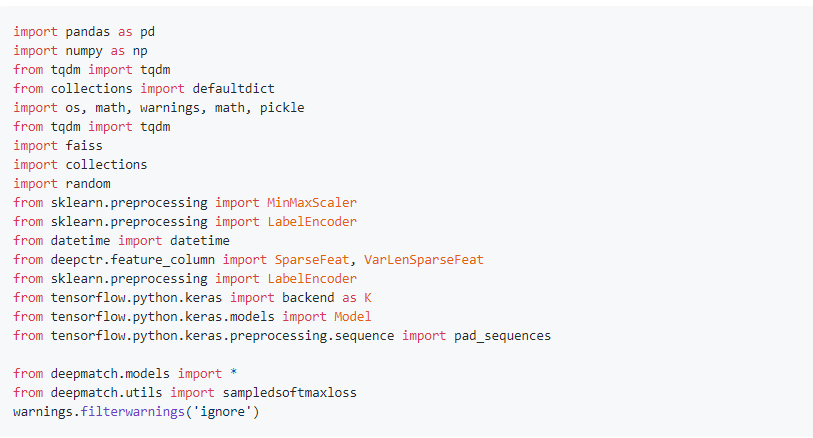

### 读取数据

推荐系统比赛中，读取数据主要采用以下三种模式，不同模式使用的数据集不同。
1. Debug模式：该模式从海量数据的训练集中随机抽取一部分样本，进行代码调试，用于搭建Baseline框架并跑通。
2. 线下验证模式：该模式读取整个训练集数据，拆分为训练集和验证集，用于模型和超参数训练。
3. 线上模式：该模式使用全量的数据集（包括训练数据+测试数据），使用debug搭建好的baseline，以及线下模式训练好的模型和超参数，对测试集进行预测，提交至线上。

本次项目中，我们需要读取的数据有文章的基本属性、文章embedding数据、用户点击日志。

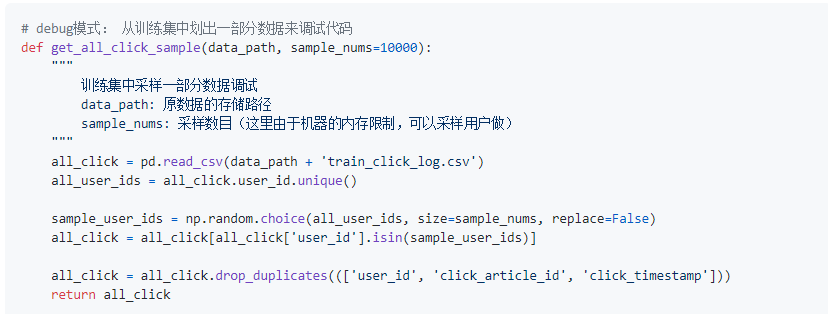

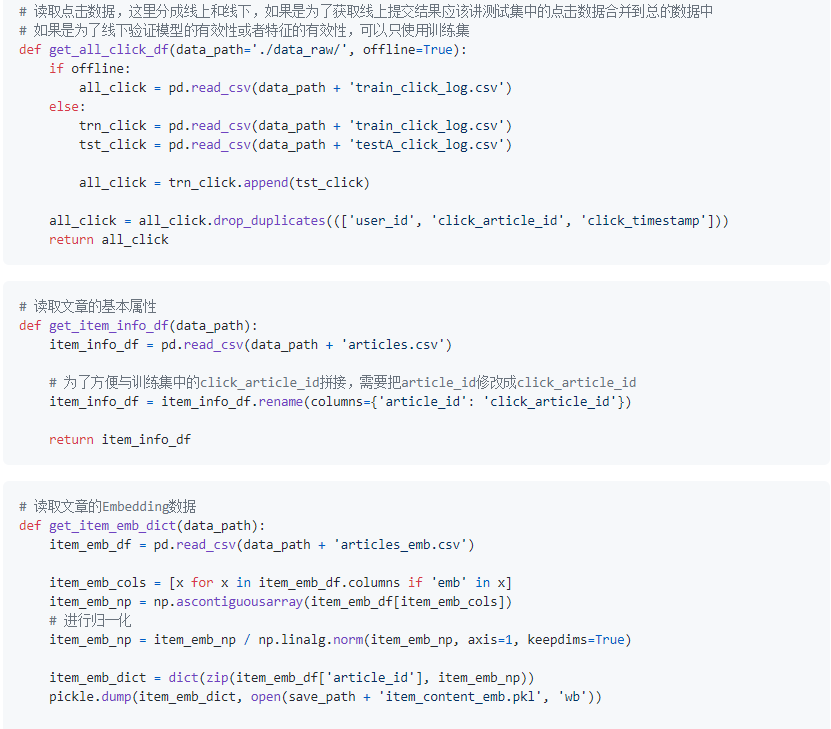

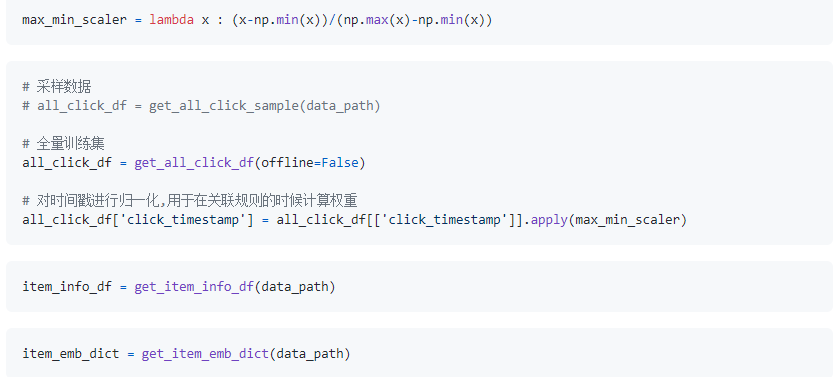

### 获取模型标签数据

我们将用户下一次点击文章预测问题转化为一个监督学习问题。基于用户历史点击行为，预测用户下一次点击不同文章的概率。训练数据为用户最后一次点击前的所有历史点击数据，标签为用户最后一次点击文章。

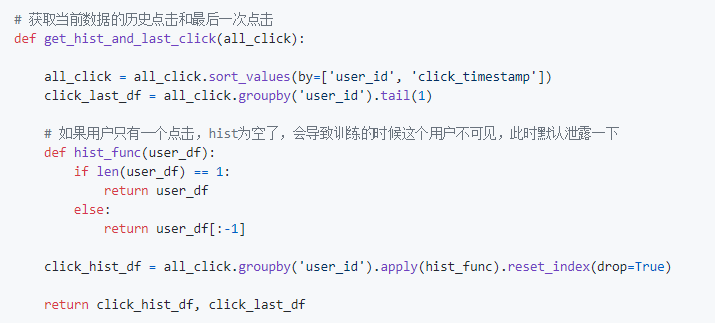

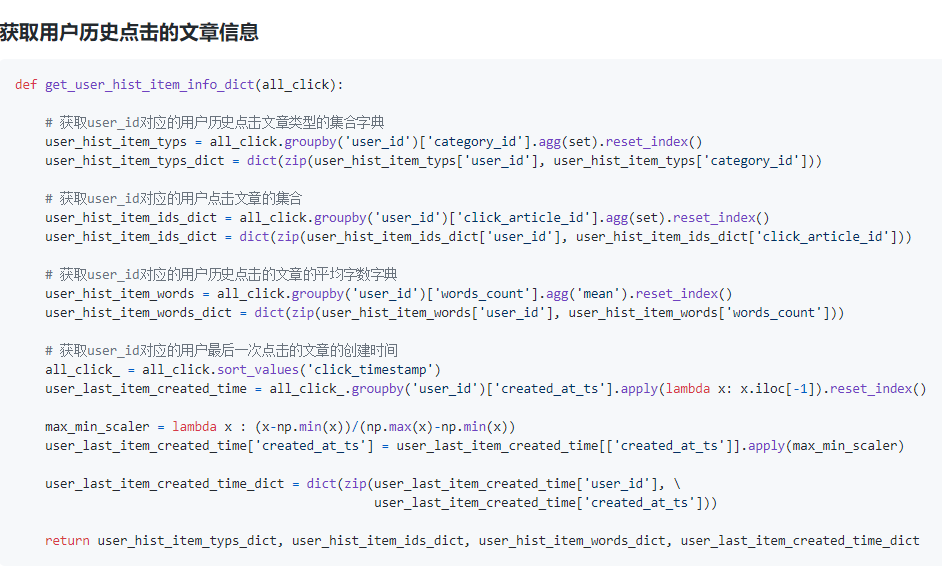

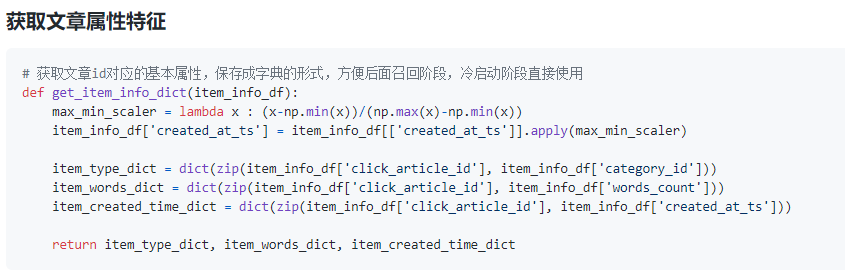

### 召回策略1-基于关联规则的用户协同过滤

#### 构建用户-文章-时间函数

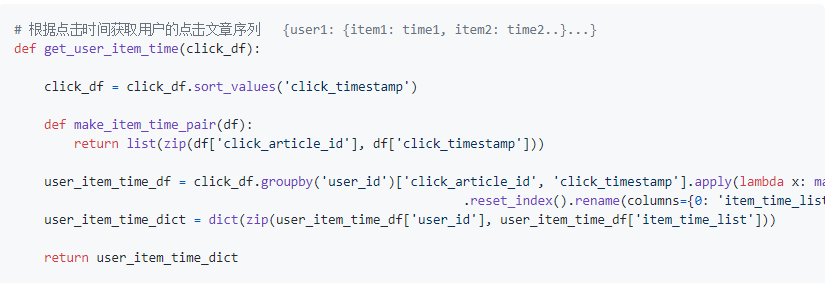

#### 计算用户与用户的相似性矩阵

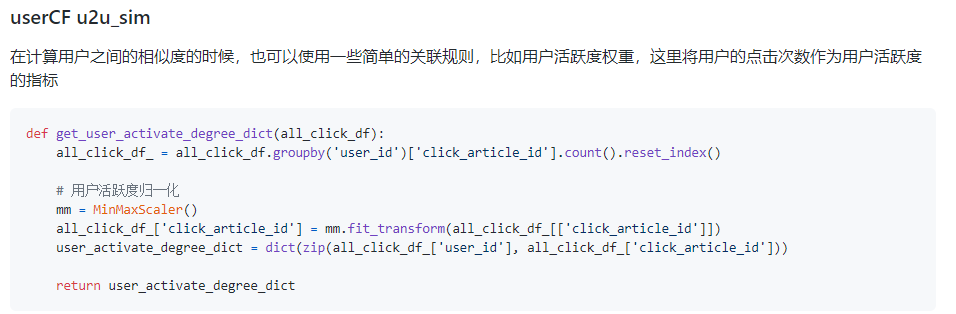
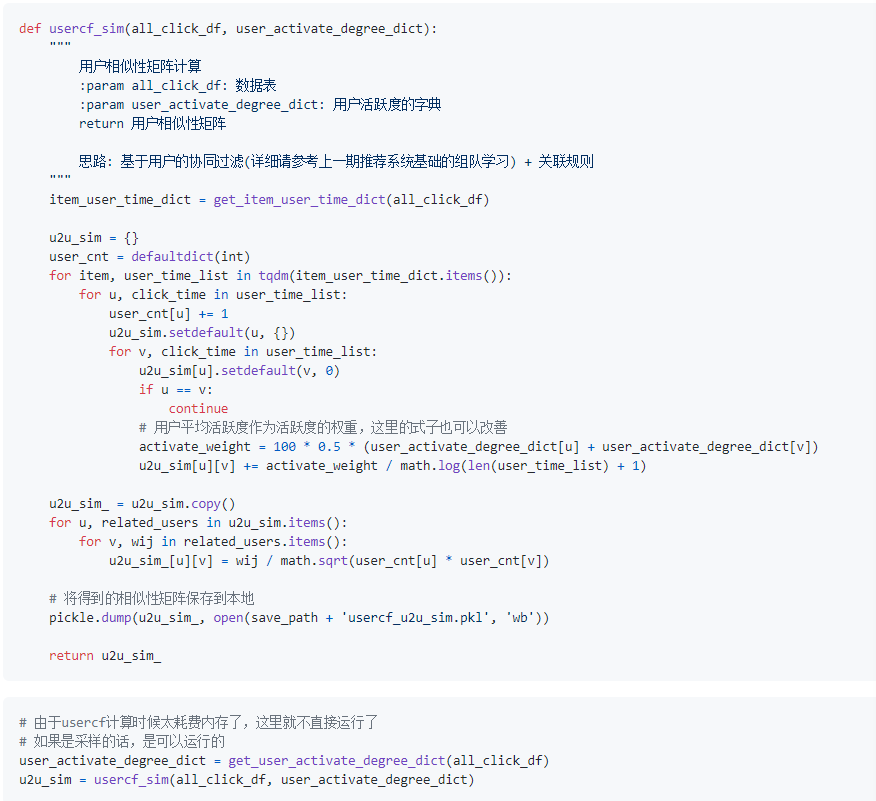

### 召回策略2-基于关联规则的文章协同过滤

#### 构建文章-用户-时间函数

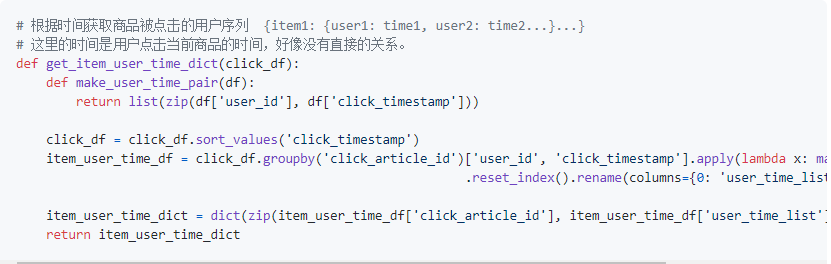

#### 计算文章与文章的相似性矩阵

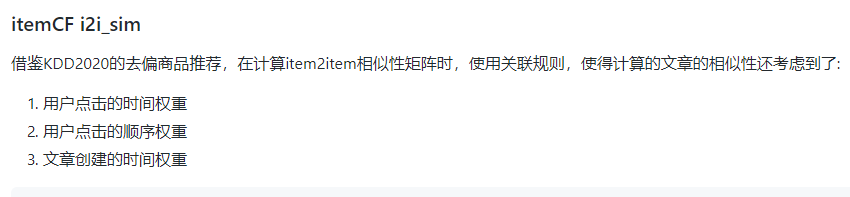
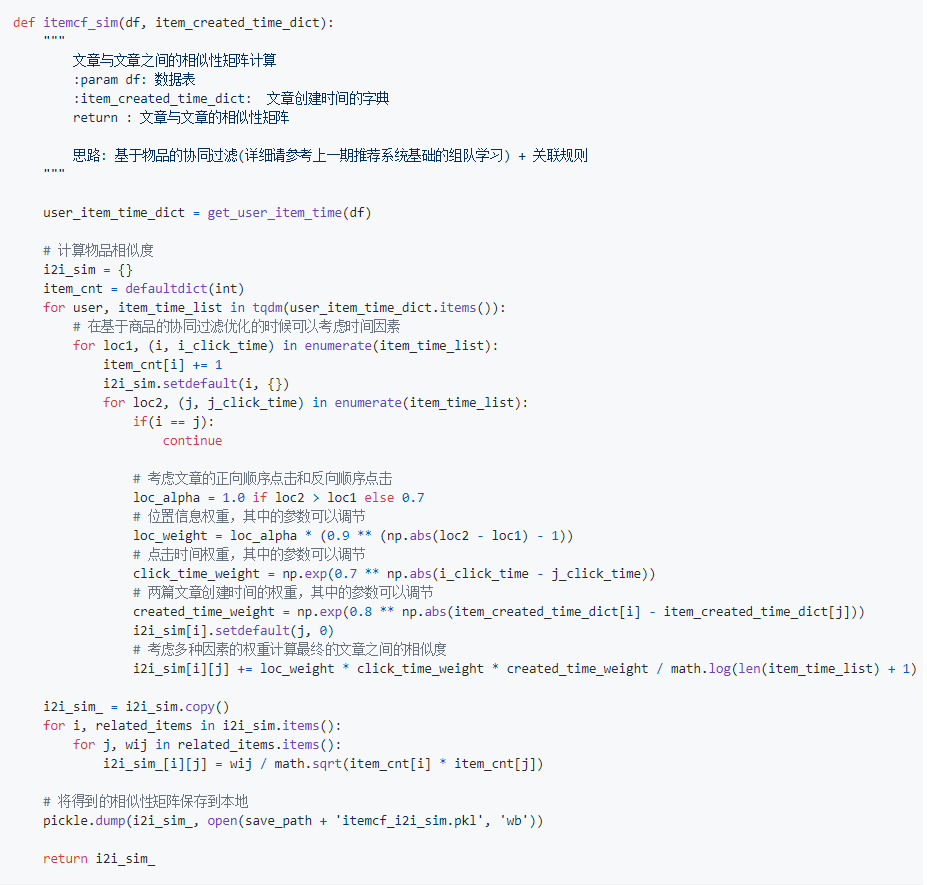

#### 使用文章embedding计算相似性矩阵

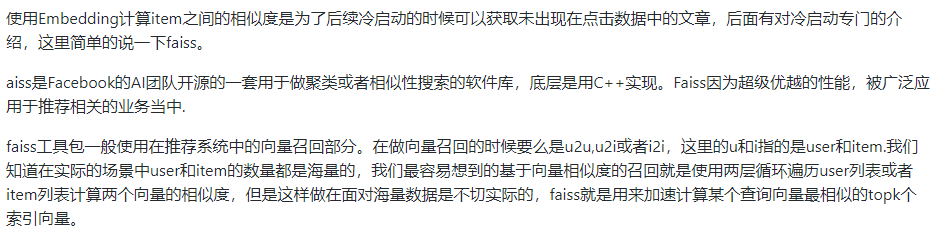
faiss查询的原理：

faiss使用了PCA和PQ(Product quantization乘积量化)两种技术进行向量压缩和编码，当然还使用了其他的技术进行优化，但是PCA和PQ是其中最核心部分。

PCA降维算法细节参考下面这个链接进行学习
主成分分析（PCA）原理总结:https://www.cnblogs.com/pinard/p/6239403.html

PQ编码的细节下面这个链接进行学习
实例理解product quantization算法:http://www.fabwrite.com/productquantization

faiss使用

faiss官方教程:https://github.com/facebookresearch/faiss/wiki/Getting-started

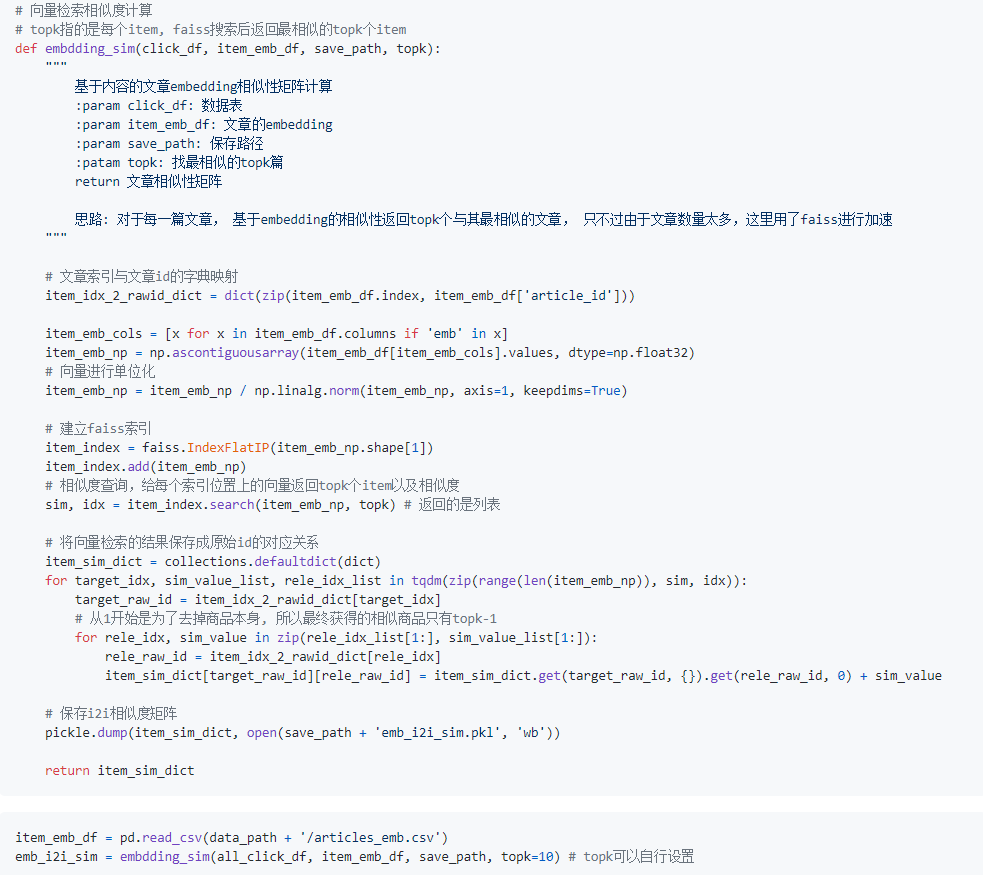

### 多路召回

面对36万篇文章， 20多万用户的推荐， 我们有哪些策略来缩减问题的规模？ 我们就可以在召回阶段筛选出用户对于点击文章的候选集合， 从而降低问题的规模。召回常用的策略：

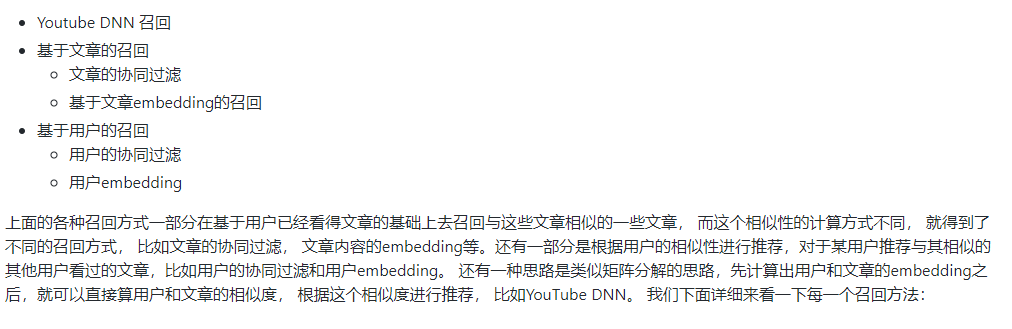

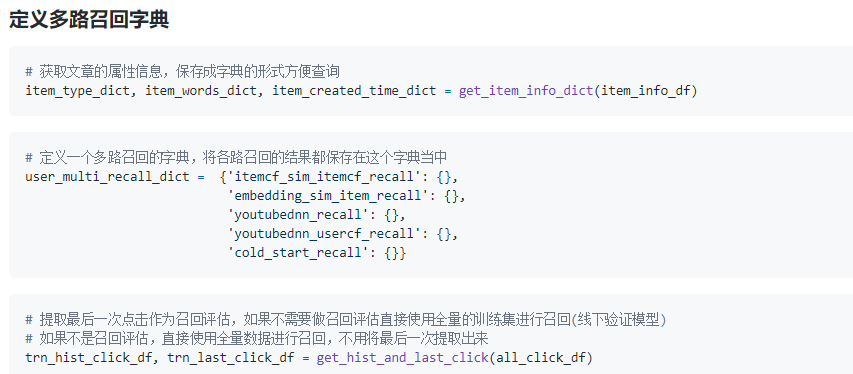

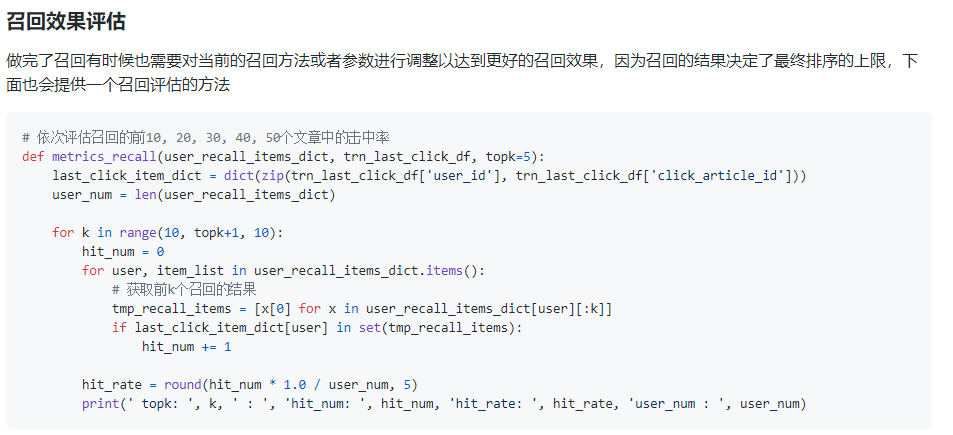

#### YoutubeDNN召回

(这一步是直接获取用户召回的候选文章列表)

论文下载地址：https://static.googleusercontent.com/media/research.google.com/zh-CN//pubs/archive/45530.pdf

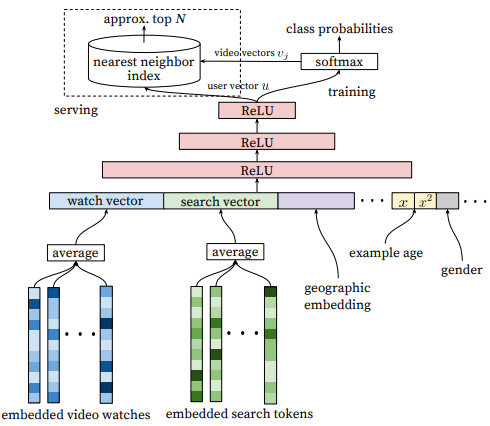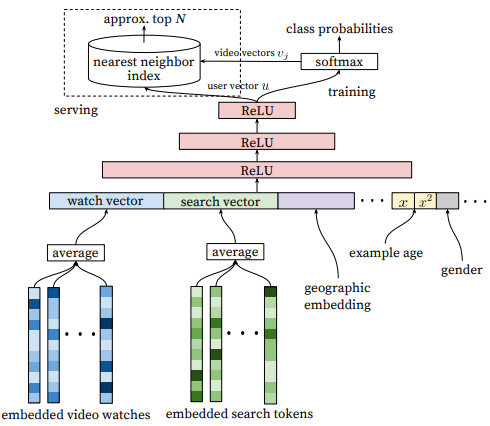

关于YoutubeDNN原理和应用推荐看王喆的两篇博客：

1. 重读Youtube深度学习推荐系统论文，字字珠玑，惊为神文：https://zhuanlan.zhihu.com/p/52169807
2. YouTube深度学习推荐系统的十大工程问题：https://zhuanlan.zhihu.com/p/52504407

参考文献:

- https://zhuanlan.zhihu.com/p/52169807 (YouTubeDNN原理)
- https://zhuanlan.zhihu.com/p/26306795 (Word2Vec知乎众赞文章) --- word2vec放到排序中的w2v的介绍部分

In [1]:
# 获取双塔召回时的训练验证数据
# negsample指的是通过滑窗构建样本的时候，负样本的数量
def gen_data_set(data, negsample=0):
    data.sort_values("click_timestamp", inplace=True)
    item_ids = data['click_article_id'].unique()

    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['click_article_id'].tolist()
        
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))   # 用户没看过的文章里面选择负样本
            neg_list = np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True)  # 对于每个正样本，选择n个负样本
            
        # 长度只有一个的时候，需要把这条数据也放到训练集中，不然的话最终学到的embedding就会有缺失
        if len(pos_list) == 1:
            train_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            test_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            
        # 滑窗构造正负样本
        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            
            if i != len(pos_list) - 1:
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1])))  # 正样本 [user_id, his_item, pos_item, label, len(his_item)]
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0,len(hist[::-1]))) # 负样本 [user_id, his_item, neg_item, label, len(his_item)]
            else:
                # 将最长的那一个序列长度作为测试数据
                test_set.append((reviewerID, hist[::-1], pos_list[i],1,len(hist[::-1])))
                
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    return train_set, test_set

# 将输入的数据进行padding，使得序列特征的长度都一致
def gen_model_input(train_set,user_profile,seq_max_len):

    train_uid = np.array([line[0] for line in train_set])
    train_seq = [line[1] for line in train_set]
    train_iid = np.array([line[2] for line in train_set])
    train_label = np.array([line[3] for line in train_set])
    train_hist_len = np.array([line[4] for line in train_set])

    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    train_model_input = {"user_id": train_uid, "click_article_id": train_iid, "hist_article_id": train_seq_pad,
                         "hist_len": train_hist_len}

    return train_model_input, train_label

In [2]:
def youtubednn_u2i_dict(data, topk=20):    
    sparse_features = ["click_article_id", "user_id"]
    SEQ_LEN = 30 # 用户点击序列的长度，短的填充，长的截断
    
    user_profile_ = data[["user_id"]].drop_duplicates('user_id')
    item_profile_ = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    # 类别编码
    features = ["click_article_id", "user_id"]
    feature_max_idx = {}
    
    for feature in features:
        lbe = LabelEncoder()
        data[feature] = lbe.fit_transform(data[feature])
        feature_max_idx[feature] = data[feature].max() + 1
    
    # 提取user和item的画像，这里具体选择哪些特征还需要进一步的分析和考虑
    user_profile = data[["user_id"]].drop_duplicates('user_id')
    item_profile = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    user_index_2_rawid = dict(zip(user_profile['user_id'], user_profile_['user_id']))
    item_index_2_rawid = dict(zip(item_profile['click_article_id'], item_profile_['click_article_id']))
    
    # 划分训练和测试集
    # 由于深度学习需要的数据量通常都是非常大的，所以为了保证召回的效果，往往会通过滑窗的形式扩充训练样本
    train_set, test_set = gen_data_set(data, 0)
    # 整理输入数据，具体的操作可以看上面的函数
    train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
    test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)
    
    # 确定Embedding的维度
    embedding_dim = 16
    
    # 将数据整理成模型可以直接输入的形式
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_article_id', feature_max_idx['click_article_id'], embedding_dim,
                                                        embedding_name="click_article_id"), SEQ_LEN, 'mean', 'hist_len'),]
    item_feature_columns = [SparseFeat('click_article_id', feature_max_idx['click_article_id'], embedding_dim)]
    
    # 模型的定义 
    # num_sampled: 负采样时的样本数量
    model = YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, user_dnn_hidden_units=(64, embedding_dim))
    # 模型编译
    model.compile(optimizer="adam", loss=sampledsoftmaxloss)  
    
    # 模型训练，这里可以定义验证集的比例，如果设置为0的话就是全量数据直接进行训练
    history = model.fit(train_model_input, train_label, batch_size=256, epochs=1, verbose=1, validation_split=0.0)
    
    # 训练完模型之后,提取训练的Embedding，包括user端和item端
    test_user_model_input = test_model_input
    all_item_model_input = {"click_article_id": item_profile['click_article_id'].values}

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
    
    # 保存当前的item_embedding 和 user_embedding 排序的时候可能能够用到，但是需要注意保存的时候需要和原始的id对应
    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)
    
    # embedding保存之前归一化一下
    user_embs = user_embs / np.linalg.norm(user_embs, axis=1, keepdims=True)
    item_embs = item_embs / np.linalg.norm(item_embs, axis=1, keepdims=True)
    
    # 将Embedding转换成字典的形式方便查询
    raw_user_id_emb_dict = {user_index_2_rawid[k]: \
                                v for k, v in zip(user_profile['user_id'], user_embs)}
    raw_item_id_emb_dict = {item_index_2_rawid[k]: \
                                v for k, v in zip(item_profile['click_article_id'], item_embs)}
    # 将Embedding保存到本地
    pickle.dump(raw_user_id_emb_dict, open(save_path + 'user_youtube_emb.pkl', 'wb'))
    pickle.dump(raw_item_id_emb_dict, open(save_path + 'item_youtube_emb.pkl', 'wb'))
    
    # faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item
    index = faiss.IndexFlatIP(embedding_dim)
    # 上面已经进行了归一化，这里可以不进行归一化了
#     faiss.normalize_L2(user_embs)
#     faiss.normalize_L2(item_embs)
    index.add(item_embs) # 将item向量构建索引
    sim, idx = index.search(np.ascontiguousarray(user_embs), topk) # 通过user去查询最相似的topk个item
    
    user_recall_items_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(test_user_model_input['user_id'], sim, idx)):
        target_raw_id = user_index_2_rawid[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index_2_rawid[rele_idx]
            user_recall_items_dict[target_raw_id][rele_raw_id] = user_recall_items_dict.get(target_raw_id, {})\
                                                                    .get(rele_raw_id, 0) + sim_value
            
    user_recall_items_dict = {k: sorted(v.items(), key=lambda x: x[1], reverse=True) for k, v in user_recall_items_dict.items()}
    # 将召回的结果进行排序
    
    # 保存召回的结果
    # 这里是直接通过向量的方式得到了召回结果，相比于上面的召回方法，上面的只是得到了i2i及u2u的相似性矩阵，还需要进行协同过滤召回才能得到召回结果
    # 可以直接对这个召回结果进行评估，为了方便可以统一写一个评估函数对所有的召回结果进行评估
    pickle.dump(user_recall_items_dict, open(save_path + 'youtube_u2i_dict.pkl', 'wb'))
    return user_recall_items_dict

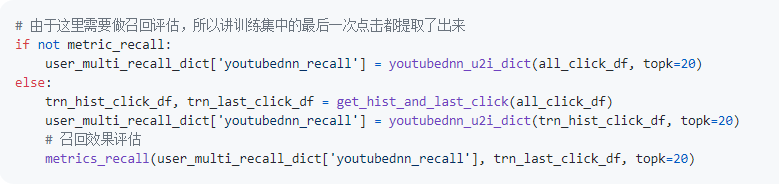

#### 基于文章的召回

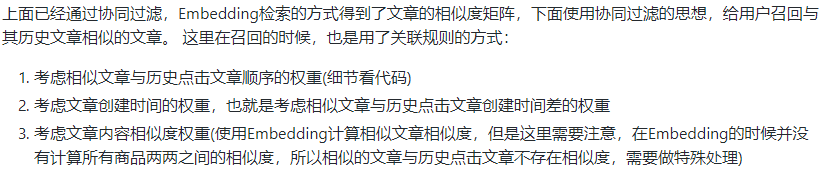

In [3]:
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: {item1: time1, item2: time2..}...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 {item1:score1, item2: score2...}
        
    """
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items:
                continue
            
            # 文章创建时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重
            loc_weight = (0.9 ** (len(user_hist_items) - loc))
            
            content_weight = 1.0
            if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                content_weight += emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                content_weight += emb_i2i_sim[j][i]
                
            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items(): # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

In [ ]:
# 先进行itemcf召回, 为了召回评估，所以提取最后一次点击

if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))
emb_i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl', 'rb'))

sim_item_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, \
                                                        i2i_sim, sim_item_topk, recall_item_num, \
                                                        item_topk_click, item_created_time_dict, emb_i2i_sim)

user_multi_recall_dict['itemcf_sim_itemcf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['itemcf_sim_itemcf_recall'], open(save_path + 'itemcf_recall_dict.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['itemcf_sim_itemcf_recall'], trn_last_click_df, topk=recall_item_num)

In [ ]:
# embedding 召回
# 这里是为了召回评估，所以提取最后一次点击
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb'))

sim_item_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, 
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['embedding_sim_item_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['embedding_sim_item_recall'], open(save_path + 'embedding_sim_item_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['embedding_sim_item_recall'], trn_last_click_df, topk=recall_item_num)

#### 基于用户的召回

基于用户协同过滤，核心思想是给用户推荐与其相似的用户历史点击文章，因为这里涉及到了相似用户的历史文章，这里仍然可以加上一些关联规则来给用户可能点击的文章进行加权，这里使用的关联规则主要是考虑相似用户的历史点击文章与被推荐用户历史点击商品的关系权重，而这里的关系就可以直接借鉴基于物品的协同过滤相似的做法，只不过这里是对被推荐物品关系的一个累加的过程，下面是使用的一些关系权重，及相关的代码：

计算被推荐用户历史点击文章与相似用户历史点击文章的相似度，文章创建时间差，相对位置的总和，作为各自的权重

In [ ]:
# 基于用户的召回 u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num, 
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: {item1: time1, item2: time2..}...}
        :param u2u_sim: 字典，文章相似性矩阵
        :param sim_user_topk: 整数， 选择与当前用户最相似的前k个用户
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param item_created_time_dict: 文章创建时间列表
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 {item1:score1, item2: score2...}
    """
    # 历史交互
    user_item_time_list = user_item_time_dict[user_id]    # {item1: time1, item2: time2...}
    user_hist_items = set([i for i, t in user_item_time_list])   # 存在一个用户与某篇文章的多次交互， 这里得去重
    
    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)
            
            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0
            
            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # 内容相似性权重
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]
                
                # 创建时间差权重
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                
            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv
        
    # 热度补全
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank.items(): # 填充的item应该不在原来的列表中
                continue
            items_rank[item] = - i - 100 # 随便给个复数就行
            if len(items_rank) == recall_item_num:
                break
        
    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]    
    
    return items_rank

In [ ]:
# 这里是为了召回评估，所以提取最后一次点击
# 由于usercf中计算user之间的相似度的过程太费内存了，全量数据这里就没有跑，跑了一个采样之后的数据
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df
    
user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)

u2u_sim = pickle.load(open(save_path + 'usercf_u2u_sim.pkl', 'rb'))

sim_user_topk = 20
recall_item_num = 10
item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)    

pickle.dump(user_recall_items_dict, open(save_path + 'usercf_u2u2i_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_recall_items_dict, trn_last_click_df, topk=recall_item_num)

- embedding 召回

虽然没有直接跑usercf的计算用户之间的相似度，为了验证上述基于用户的协同过滤的代码，下面使用了YoutubeDNN过程中产生的user embedding来进行向量检索每个user最相似的topk个user，在使用这里得到的u2u的相似性矩阵，使用usercf进行召回，具体代码如下


In [ ]:
# 使用Embedding的方式获取u2u的相似性矩阵
# topk指的是每个user, faiss搜索后返回最相似的topk个user
def u2u_embdding_sim(click_df, user_emb_dict, save_path, topk):
    
    user_list = []
    user_emb_list = []
    for user_id, user_emb in user_emb_dict.items():
        user_list.append(user_id)
        user_emb_list.append(user_emb)
        
    user_index_2_rawid_dict = {k: v for k, v in zip(range(len(user_list)), user_list)}    
    
    user_emb_np = np.array(user_emb_list, dtype=np.float32)
    
    # 建立faiss索引
    user_index = faiss.IndexFlatIP(user_emb_np.shape[1])
    user_index.add(user_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = user_index.search(user_emb_np, topk) # 返回的是列表
   
    # 将向量检索的结果保存成原始id的对应关系
    user_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(user_emb_np)), sim, idx)):
        target_raw_id = user_index_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = user_index_2_rawid_dict[rele_idx]
            user_sim_dict[target_raw_id][rele_raw_id] = user_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(user_sim_dict, open(save_path + 'youtube_u2u_sim.pkl', 'wb'))   
    return user_sim_dict

# 读取YoutubeDNN过程中产生的user embedding, 然后使用faiss计算用户之间的相似度
# 这里需要注意，这里得到的user embedding其实并不是很好，因为YoutubeDNN中使用的是用户点击序列来训练的user embedding,
# 如果序列普遍都比较短的话，其实效果并不是很好
user_emb_dict = pickle.load(open(save_path + 'user_youtube_emb.pkl', 'rb'))
u2u_sim = u2u_embdding_sim(all_click_df, user_emb_dict, save_path, topk=10)

In [ ]:
# 通过YoutubeDNN得到的user_embedding

# 使用召回评估函数验证当前召回方式的效果
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
u2u_sim = pickle.load(open(save_path + 'youtube_u2u_sim.pkl', 'rb'))

sim_user_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['youtubednn_usercf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['youtubednn_usercf_recall'], open(save_path + 'youtubednn_usercf_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['youtubednn_usercf_recall'], trn_last_click_df, topk=recall_item_num)

#### 冷启动问题

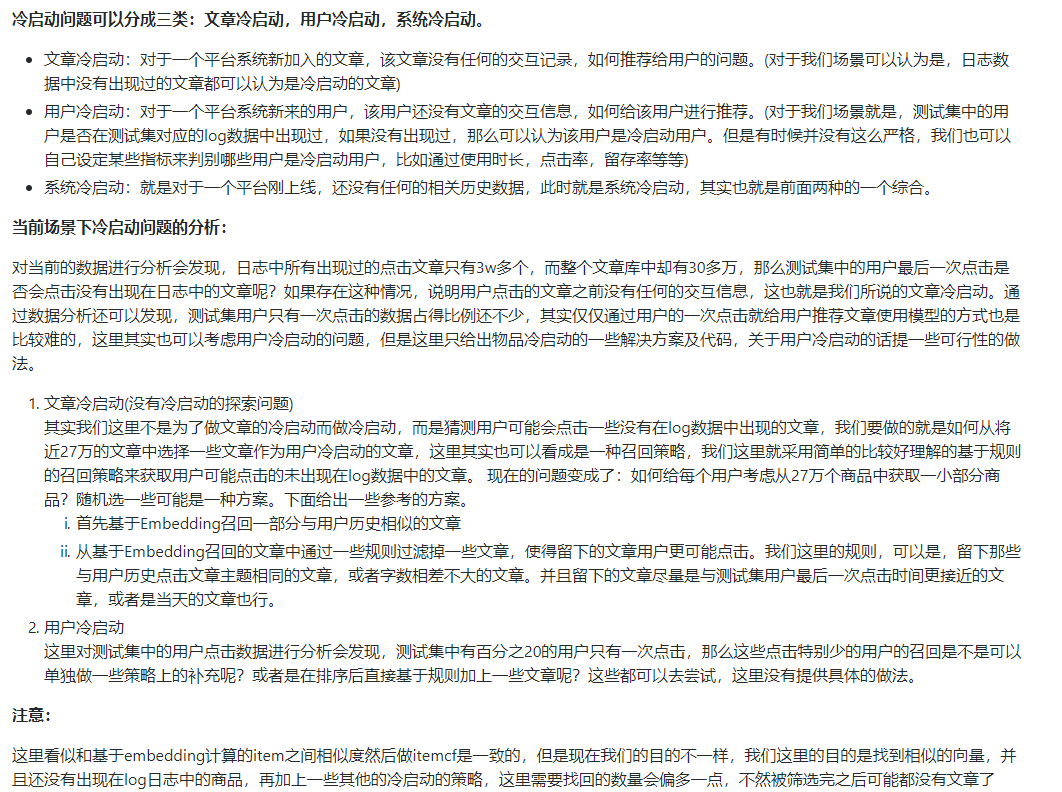

In [ ]:
# 先进行itemcf召回，这里不需要做召回评估，这里只是一种策略
trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb'))

sim_item_topk = 150
recall_item_num = 100 # 稍微召回多一点文章，便于后续的规则筛选

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, 
                                                        recall_item_num, item_topk_click,item_created_time_dict, emb_i2i_sim)
pickle.dump(user_recall_items_dict, open(save_path + 'cold_start_items_raw_dict.pkl', 'wb'))

In [ ]:
# 基于规则进行文章过滤
# 保留文章主题与用户历史浏览主题相似的文章
# 保留文章字数与用户历史浏览文章字数相差不大的文章
# 保留最后一次点击当天的文章
# 按照相似度返回最终的结果

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                     user_last_item_created_time_dict, item_type_dict, item_words_dict, 
                     item_created_time_dict, click_article_ids_set, recall_item_num):
    """
        冷启动的情况下召回一些文章
        :param user_recall_items_dict: 基于内容embedding相似性召回来的很多文章， 字典， {user1: [item1, item2, ..], }
        :param user_hist_item_typs_dict: 字典， 用户点击的文章的主题映射
        :param user_hist_item_words_dict: 字典， 用户点击的历史文章的字数映射
        :param user_last_item_created_time_idct: 字典，用户点击的历史文章创建时间映射
        :param item_tpye_idct: 字典，文章主题映射
        :param item_words_dict: 字典，文章字数映射
        :param item_created_time_dict: 字典， 文章创建时间映射
        :param click_article_ids_set: 集合，用户点击过得文章, 也就是日志里面出现过的文章
        :param recall_item_num: 召回文章的数量， 这个指的是没有出现在日志里面的文章数量
    """
    
    cold_start_user_items_dict = {}
    for user, item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user, [])
        for item, score in item_list:
            # 获取历史文章信息
            hist_item_type_set = user_hist_item_typs_dict[user]
            hist_mean_words = user_hist_item_words_dict[user]
            hist_last_item_created_time = user_last_item_created_time_dict[user]
            hist_last_item_created_time = datetime.fromtimestamp(hist_last_item_created_time)
            
            # 获取当前召回文章的信息
            curr_item_type = item_type_dict[item]
            curr_item_words = item_words_dict[item]
            curr_item_created_time = item_created_time_dict[item]
            curr_item_created_time = datetime.fromtimestamp(curr_item_created_time)

            # 首先，文章不能出现在用户的历史点击中， 然后根据文章主题，文章单词数，文章创建时间进行筛选
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words - hist_mean_words) > 200 or \
                abs((curr_item_created_time - hist_last_item_created_time).days) > 90: 
                continue
                
            cold_start_user_items_dict[user].append((item, score))      # {user1: [(item1, score1), (item2, score2)..]...}
    
    # 需要控制一下冷启动召回的数量
    cold_start_user_items_dict = {k: sorted(v, key=lambda x:x[1], reverse=True)[:recall_item_num] \
                                  for k, v in cold_start_user_items_dict.items()}
    
    pickle.dump(cold_start_user_items_dict, open(save_path + 'cold_start_user_items_dict.pkl', 'wb'))
    
    return cold_start_user_items_dict

In [ ]:
all_click_df_ = all_click_df.copy()
all_click_df_ = all_click_df_.merge(item_info_df, how='left', on='click_article_id')
user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict = get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_click_df)
# 需要注意的是
# 这里使用了很多规则来筛选冷启动的文章，所以前面再召回的阶段就应该尽可能的多召回一些文章，否则很容易被删掉
cold_start_user_items_dict = cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)

user_multi_recall_dict['cold_start_recall'] = cold_start_user_items_dict

#### 多路召回结果合并

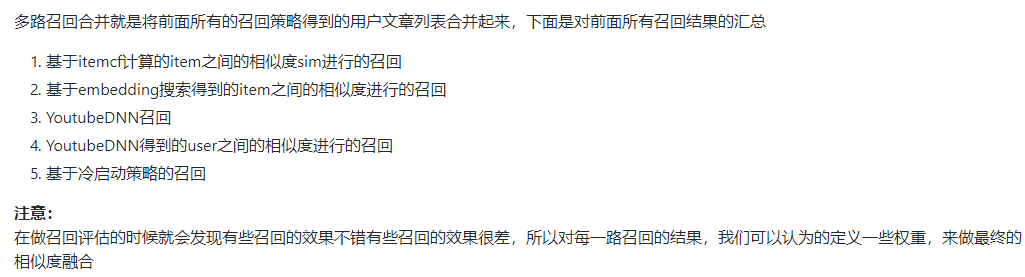

In [ ]:
def combine_recall_results(user_multi_recall_dict, weight_dict=None, topk=25):
    final_recall_items_dict = {}
    
    # 对每一种召回结果按照用户进行归一化，方便后面多种召回结果，相同用户的物品之间权重相加
    def norm_user_recall_items_sim(sorted_item_list):
        # 如果冷启动中没有文章或者只有一篇文章，直接返回，出现这种情况的原因可能是冷启动召回的文章数量太少了，
        # 基于规则筛选之后就没有文章了, 这里还可以做一些其他的策略性的筛选
        if len(sorted_item_list) < 2:
            return sorted_item_list
        
        min_sim = sorted_item_list[-1][1]
        max_sim = sorted_item_list[0][1]
        
        norm_sorted_item_list = []
        for item, score in sorted_item_list:
            if max_sim > 0:
                norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
            else:
                norm_score = 0.0
            norm_sorted_item_list.append((item, norm_score))
            
        return norm_sorted_item_list
    
    print('多路召回合并...')
    for method, user_recall_items in tqdm(user_multi_recall_dict.items()):
        print(method + '...')
        # 在计算最终召回结果的时候，也可以为每一种召回结果设置一个权重
        if weight_dict == None:
            recall_method_weight = 1
        else:
            recall_method_weight = weight_dict[method]
        
        for user_id, sorted_item_list in user_recall_items.items(): # 进行归一化
            user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)
        
        for user_id, sorted_item_list in user_recall_items.items():
            # print('user_id')
            final_recall_items_dict.setdefault(user_id, {})
            for item, score in sorted_item_list:
                final_recall_items_dict[user_id].setdefault(item, 0)
                final_recall_items_dict[user_id][item] += recall_method_weight * score  
    
    final_recall_items_dict_rank = {}
    # 多路召回时也可以控制最终的召回数量
    for user, recall_item_dict in final_recall_items_dict.items():
        final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

    # 将多路召回后的最终结果字典保存到本地
    pickle.dump(final_recall_items_dict, open(os.path.join(save_path, 'final_recall_items_dict.pkl'),'wb'))

    return final_recall_items_dict_rank

In [ ]:
# 这里直接对多路召回的权重给了一个相同的值，其实可以根据前面召回的情况来调整参数的值
weight_dict = {'itemcf_sim_itemcf_recall': 1.0,
               'embedding_sim_item_recall': 1.0,
               'youtubednn_recall': 1.0,
               'youtubednn_usercf_recall': 1.0, 
               'cold_start_recall': 1.0}
# 最终合并之后每个用户召回150个商品进行排序
final_recall_items_dict_rank = combine_recall_results(user_multi_recall_dict, weight_dict, topk=150)

### 总结

本次学习介绍了几种常用的召回策略，以及具体的实现思路和代码。当然，可以选用额召回策略还有很多，都可以去进行尝试，比如对新闻进行热度召回等。